In [1]:
%load_ext autoreload
%autoreload 2

import os,sys
import datetime as dt
import pandas as pd

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.insert(0, '/scratch/users/udemir15/ELEC491/bassline_transcription')

from utilities import *

In [28]:
def load_data(data_params):     
    dataset_path, scale_type, M = data_params['dataset_path'], data_params['scale_type'], data_params['M']    
    dataset_name = data_params['dataset_name'] +'_{}_M{}.csv'.format(scale_type, M)
    dataset_dir = os.path.join(dataset_path, dataset_name)
    df = pd.read_csv(dataset_dir, header=None)
    titles = df[0].tolist()
    X = df[df.columns[1:]].to_numpy()    
    return X, titles

def append_SOS(X, SOS_token=-1):
    X = np.concatenate( (SOS_token*np.ones((X.shape[0],1), dtype=np.int64), X), axis=1)    
    return X+1 

def count_same_phrases(vector, M, counter):
    
    vector_re = vector.reshape((4,4, 4*(8//M)))
    
    for b in range(4):

        bars = vector_re[:,b,:] # beat b for all bars

        for i in range(4):
            for j in range(i+1,4):

                B0 = bars[i,:]
                B1 = bars[j,:]

                if np.array_equal(B0, B1):
                    key = '{}{}'.format(i,j)
                    counter[b][key] += 1
                    
    return counter    

## Initialization

In [15]:
directories = get_directories('../data/directories.json')

In [67]:
M = 8

data_params = {'dataset_path': '/scratch/users/udemir15/ELEC491/bassline_transcription/data/datasets/[28, 51]',
               'dataset_name': 'TechHouse_bassline_representations',
               'scale_type': 'min',
               'M': M}

X, titles = load_data(data_params)
#X = append_SOS(X)

frequencies = np.unique(X, return_counts=True)

K = X.max()+1 # Number of classes, assumes consecutive
sequence_length = X.shape[1]

print('Number of classes: {}\nSequence Length: {}'.format(K, sequence_length))
print('Number of data points: {}'.format(X.shape[0]))

directories = get_directories('../data/directories.json')

Number of classes: 26
Sequence Length: 64
Number of data points: 4421


## Distribution Inspection

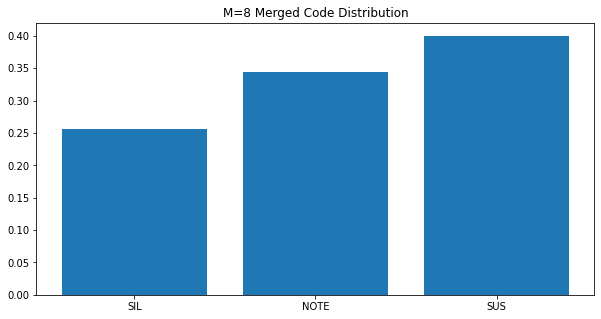

In [68]:
silence_count = frequencies[1][0]
note_count = frequencies[1][1:-1].sum()
sustain_count = frequencies[1][-1]

merged_frequencies = np.array([silence_count, note_count, sustain_count])

fig ,ax = plt.subplots(figsize=(10,5))
plot_title = 'M={} Merged Code Distribution'.format(M)
ax.set_title(plot_title, fontsize=12)
ax.bar(['SIL', 'NOTE', 'SUS'], merged_frequencies/merged_frequencies.sum())

#plt.savefig(os.path.join(directories['plot']['figures']+'/dataset', 'Merged_Code_Distribution_M{}.jpg'.format(M)))
plt.show()

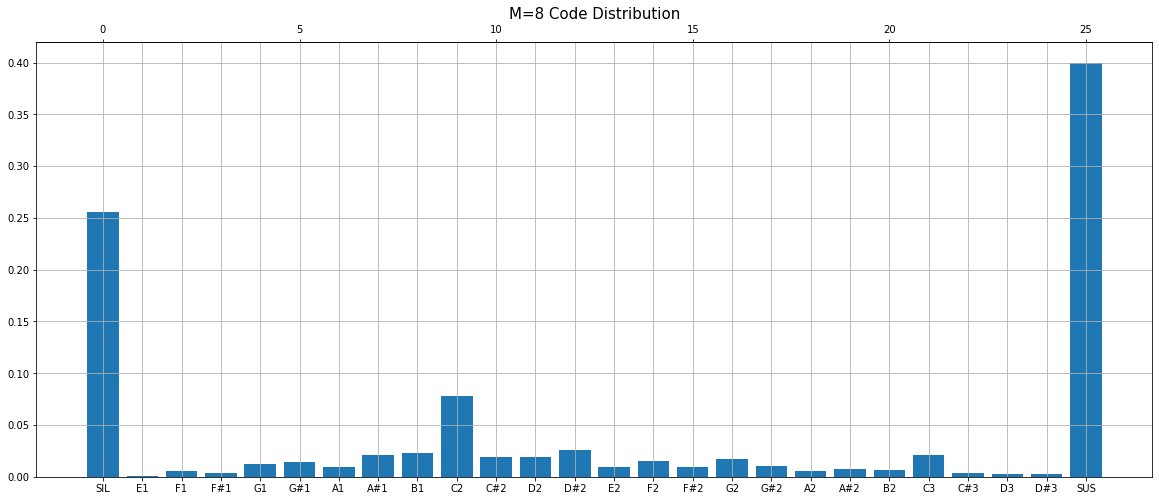

In [69]:
keys = ['SIL'] + ['E1', 'F1', 'F#1', 'G1', 'G#1', 'A1', 'A#1', 'B1']+ \
        ['C2', 'C#2', 'D2', 'D#2', 'E2', 'F2', 'F#2', 'G2', 'G#2', 'A2', 'A#2', 'B2']+ \
        ['C3', 'C#3', 'D3','D#3']+ ['SUS']

fig ,ax = plt.subplots(figsize=(20,8))
plot_title = 'M={} Code Distribution'.format(M)
ax.set_title(plot_title, fontsize=15)
ax.bar(keys, frequencies[1]/frequencies[1].sum())
ax.grid()
secax = ax.secondary_xaxis('top')

#plt.savefig(os.path.join(directories['plot']['figures']+'/dataset', 'Code_Distribution_M{}.jpg'.format(M)))
plt.show()

weights = frequencies[1].max() / frequencies[1]
weights /= weights.sum()

## Similarity Measure

In [70]:
counter = {b: {'01': 0, '02': 0, '03': 0, '12': 0, '13': 0, '23': 0} for b in range(4)}
for vector in X: #[:, 1:]:
    count_same_phrases(vector, M, counter)
    
for vals in counter.values():
    print(vals)

{'01': 619, '02': 655, '03': 497, '12': 1473, '13': 1665, '23': 1502}
{'01': 1401, '02': 1362, '03': 1081, '12': 1563, '13': 1596, '23': 1552}
{'01': 1517, '02': 1563, '03': 1112, '12': 1591, '13': 1535, '23': 1493}
{'01': 1372, '02': 1532, '03': 732, '12': 1405, '13': 1042, '23': 970}


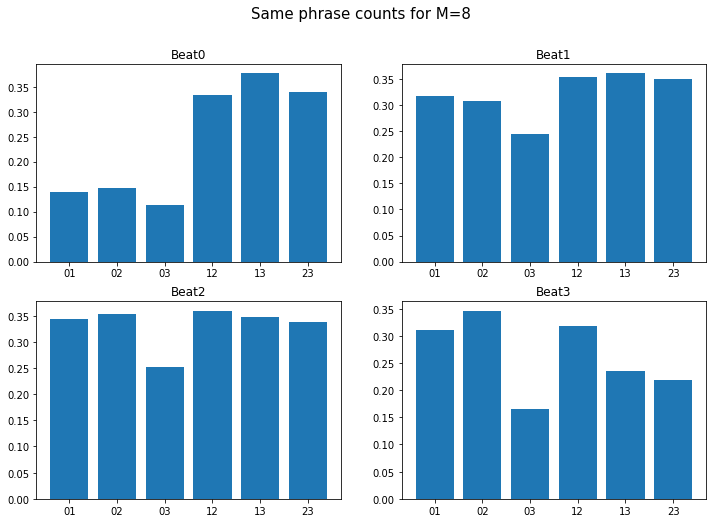

In [71]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(12,8))
fig.suptitle('Same phrase counts for M={}'.format(M), fontsize=15)

ax[0][0].bar(counter[0].keys(), np.array(list(counter[0].values()))/len(X))
ax[0][0].set_title('Beat0')
ax[0][1].bar(counter[1].keys(), np.array(list(counter[1].values()))/len(X))
ax[0][1].set_title('Beat1')
ax[1][0].bar(counter[2].keys(), np.array(list(counter[2].values()))/len(X))
ax[1][0].set_title('Beat2')
ax[1][1].bar(counter[3].keys(), np.array(list(counter[3].values()))/len(X))
ax[1][1].set_title('Beat3')

#plt.savefig(os.path.join(directories['plot']['figures']+'/dataset', 'Same_Phrase_Counts_M{}.jpg'.format(M)))
plt.show()

## Representation Printing

In [ ]:
idx = 56
title = titles[idx]
print(title)
vector = X[idx,1:]
print_beat_matrix(vector, M)
print('\n')
print_transposed_beat_matrix(vector, M)

In [ ]:
inspect_audio_outputs(title, directories, start=0, end=1)

In [ ]:
# Dreams of Morjim      | drop mistake
# Camilo Do Santos - Bubba Mint (Original Mix)   | note melodic

## New Representation

In [32]:
from bassline_transcriber.transcription.representation import encode_midi_array_new

In [72]:
#M = 1
sustain_silence=-1
sustain_note=-2

Y = np.zeros((len(titles), 4*4*(32//M)), dtype=np.int64)
for i, title in enumerate(titles):
    
    midi_array = load_bassline_midi_array(title, directories, M)
    new_representation = encode_midi_array_new(midi_array, 8, M, 4, sustain_silence=sustain_silence, sustain_note=sustain_note)
    Y[i] = new_representation
    
    
new_frequencies = np.unique(Y, return_counts=True)

new_frequencies_merged = (['SUS_NOTE', 'SUS_SIL', 'SIL', 'NOTE'], np.array([new_frequencies[1][0], new_frequencies[1][1],
                                                                   new_frequencies[1][2], new_frequencies[1][3:].sum()]))

new_frequencies_hard_merged = (['SIL', 'NOTE'], np.array([new_frequencies[1][1:3].sum(),
                                                          new_frequencies[1][0]+new_frequencies[1][3:].sum()]))

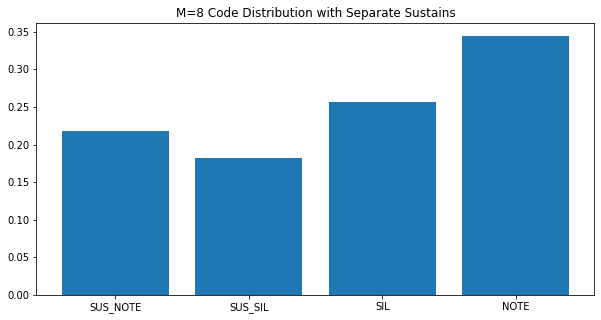

In [73]:
fig ,ax = plt.subplots(figsize=(10,5))
plot_title = 'M={} Code Distribution with Separate Sustains'.format(M)
ax.set_title(plot_title, fontsize=12)
ax.bar(new_frequencies_merged[0], new_frequencies_merged[1]/new_frequencies_merged[1].sum())

#plt.savefig(os.path.join(directories['plot']['figures']+'/dataset', 'Code_Distribution_Separate_Sustains_M{}.jpg'.format(M)))
plt.show()

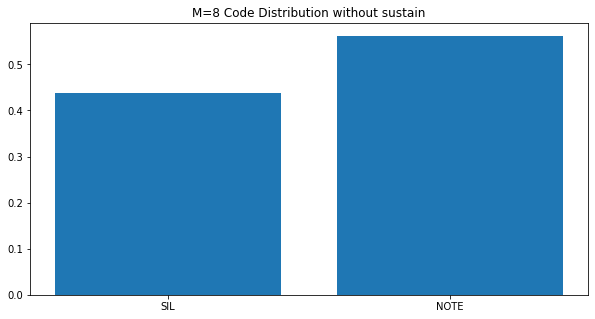

In [74]:
fig ,ax = plt.subplots(figsize=(10,5))
plot_title = 'M={} Code Distribution without sustain'.format(M)
ax.set_title(plot_title, fontsize=12)
ax.bar(new_frequencies_hard_merged[0], new_frequencies_hard_merged[1]/new_frequencies_hard_merged[1].sum())

#plt.savefig(os.path.join(directories['plot']['figures']+'/dataset', 'Code_Distribution_Without_Sustains_M{}.jpg'.format(M)))
plt.show()